<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex2/2_notebook1_GPU/ex2_1bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q seaborn
!pip install -q transformers
!pip install -q nltk
!pip install -q wordcloud
!pip install -q --upgrade pip
!pip install -q tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import transformers
import sklearn
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
os.environ['TF_DISABLE_ASSERTS'] = '0'

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [ ]:
# Check if a GPU is available and list device names
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU available.")

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# PRE-PROCESSING

In [ ]:
folder_path = "/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex2/2_notebook1_GPU"
os.chdir(folder_path)

In [ ]:
df_train = pd.read_csv('data/news_train.csv')
df_test = pd.read_csv('data/news_test.csv')

In [ ]:
df_train.shape

(120000, 3)

In [ ]:
df_test.shape

(7600, 3)

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True) # combine test and train for clarity

In [ ]:
df.shape

(127600, 3)

In [ ]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
TEXT_LABELS = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

In [ ]:
df['category'] = df['Class Index'].map(TEXT_LABELS)

In [ ]:
df.head()

,Class Index,Title,Description,category
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business


In [ ]:
# renaming columns for conveneice
df.rename(columns={'Title': 'title', 'Description': 'description'}, inplace=True)

In [ ]:
df.head()

,Class Index,title,description,category
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business


In [ ]:
df.drop(columns='Class Index', inplace=True)

In [ ]:
df.isnull().sum()

title          0
description    0
category       0
dtype: int64

In [ ]:
df.describe()

,title,description,category
count,127600,127600,127600
unique,121258,126182,4
top,Today's schedule,"With the economy slowly turning up, upgrading ...",Business
freq,43,16,31900


In [ ]:
len(df[df.duplicated()])

0

In [ ]:
print(df['category'].unique())

['Business' 'Sci/Tech' 'Sports' 'World']


In [ ]:
def combine_title_and_description(df):
    # returns a dataset with the title and description fields combined
    df['text'] = df[['title', 'description']].agg('. '.join, axis=1)
    df = df.drop(['title', 'description'], axis=1)
    return df

In [ ]:
df = combine_title_and_description(df)

In [ ]:
df.head()

,category,text
0,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [ ]:
df['category'].groupby(df['category']).count().sort_values(ascending=False)

category
Business    31900
Sci/Tech    31900
Sports      31900
World       31900
Name: category, dtype: int64

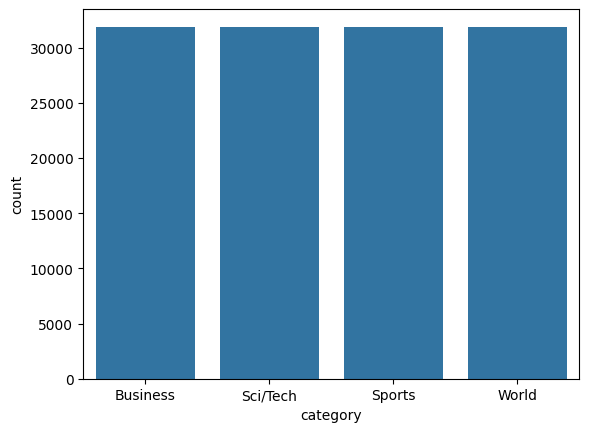

In [ ]:
sns.countplot(x="category", data=df)
plt.show()

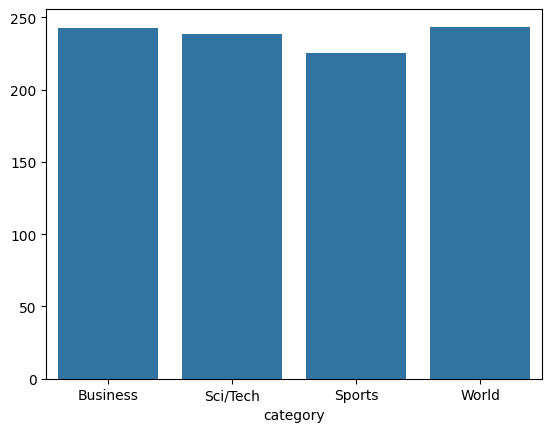

In [ ]:
df["text_length"] = df["text"].str.len()
df.groupby("category")["text_length"].mean()
sns.barplot(x=df.groupby("category")["text_length"].mean().index, y=df.groupby("category")["text_length"].mean().values)
plt.show()

In [ ]:
def remove_stopwords_and_punctuations(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    words_without_punctuations = [''.join(c for c in word if c not in string.punctuation) for word in words]
    words_preprocessed = [word.replace("‘", "").replace("’", "").replace("“"," ").replace("”"," ") for word in words_without_punctuations if len(word)>2]
    return ' '.join(words_preprocessed)

In [ ]:
df['text'] = df['text'].apply(remove_stopwords_and_punctuations)

# Tokenization

In [ ]:
def tokenize_text(text):
    return text.lower().split()

In [ ]:
df['tokenized_text'] = df['text'].apply(tokenize_text)

In [ ]:
df.head()

,category,text,text_length,tokenized_text
0,Business,Wall Bears Claw Back Black Reuters Reuters Sho...,145,"[wall, bears, claw, back, black, reuters, reut..."
1,Business,Carlyle Looks Toward Commercial Aerospace Reut...,267,"[carlyle, looks, toward, commercial, aerospace..."
2,Business,Oil Economy Cloud Stocks Outlook Reuters Reute...,233,"[oil, economy, cloud, stocks, outlook, reuters..."
3,Business,Iraq Halts Oil Exports Main Southern Pipeline ...,257,"[iraq, halts, oil, exports, main, southern, pi..."
4,Business,Oil price soar alltime record posing new menac...,235,"[oil, price, soar, alltime, record, posing, ne..."


In [ ]:
mean_length = df['text_length'].mean()
print("Average:", mean_length)

median_length = df['text_length'].median()
print("Median:", median_length)

min_length = df['text_length'].min()
print("Minimum:", min_length)

max_length = df['text_length'].max()
print("Maximum:", max_length)

Average: 237.3903605015674
Median: 233.0
Minimum: 18
Maximum: 1013


In [ ]:
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]
    word_counts = Counter(all_words)
    return word_counts.most_common(50)

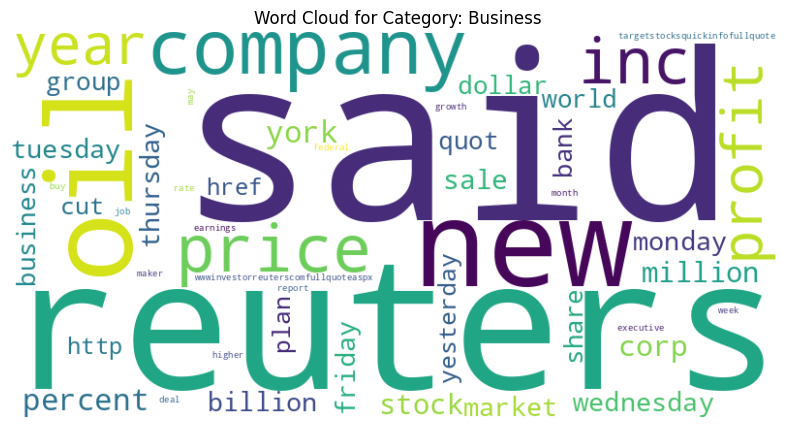

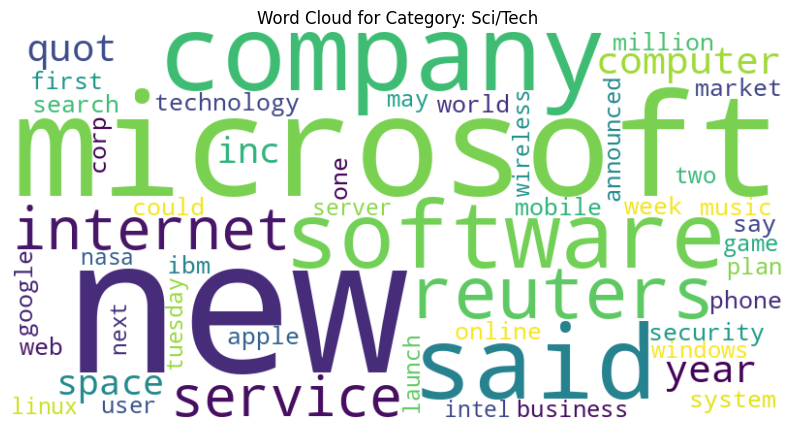

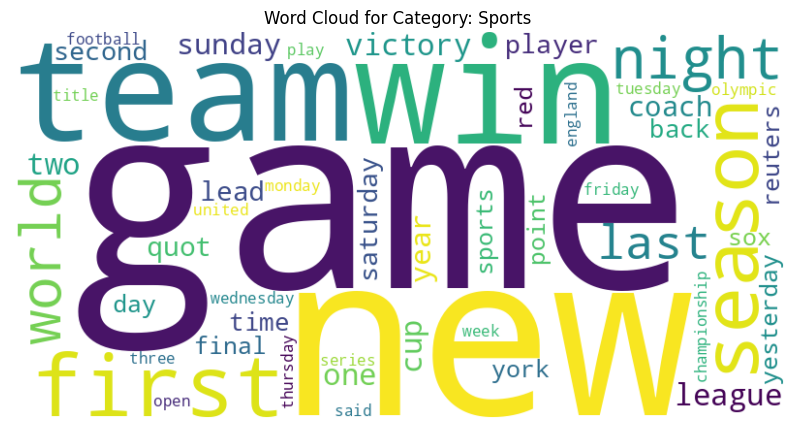

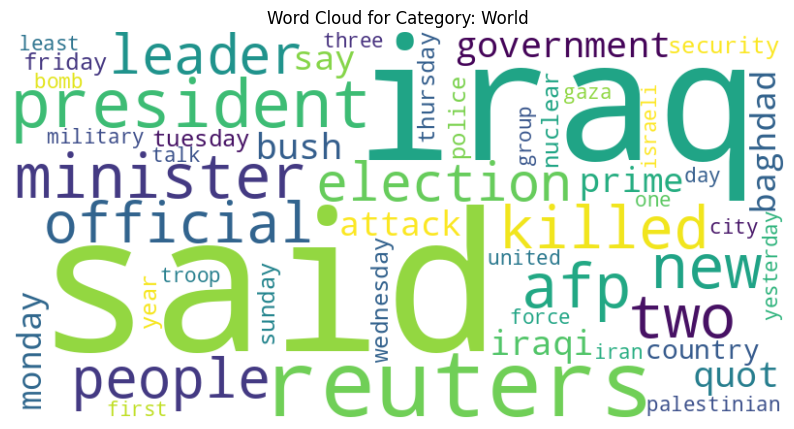

In [ ]:
top_words_by_category = df.groupby('category')['tokenized_text'].apply(count_top_words_by_category).reset_index()

for idx, row in top_words_by_category.iterrows():
    category = row['category']
    top_words = row['tokenized_text']

    word_freq_dict = dict(top_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords=stopwords).generate_from_frequencies(word_freq_dict)

    # Plots the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Category: {category}")
    plt.axis('off')
    plt.show()
    print()

In [ ]:
def count_top_words_by_category(category_list):
    all_words = [word for words in category_list for word in words]
    word_counts = Counter(all_words)
    return word_counts.most_common(10)

In [ ]:
top_words_by_category = df.groupby('category')['tokenized_text'].apply(count_top_words_by_category).reset_index()

In [ ]:
# Displays the top 10 words for each category
for idx, row in top_words_by_category.iterrows():
    category = row['category']
    top_words = row['tokenized_text']
    print(f"Category: {category}")
    print(f"Top 10 words and their count:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Category: Business
Top 10 words and their count:
said: 7699
reuters: 7289
new: 6981
oil: 6592
company: 5661
price: 5032
inc: 4693
profit: 3724
year: 3678
percent: 3575

Category: Sci/Tech
Top 10 words and their count:
new: 7553
microsoft: 5428
company: 4284
said: 3857
software: 3819
reuters: 3468
internet: 3435
service: 3349
computer: 2960
year: 2930

Category: Sports
Top 10 words and their count:
game: 5032
new: 4354
win: 4284
team: 4246
first: 4177
season: 3639
night: 3288
world: 3196
last: 2959
victory: 2942

Category: World
Top 10 words and their count:
said: 8153
iraq: 6145
reuters: 5748
president: 4529
minister: 3728
new: 3685
afp: 3661
two: 3538
killed: 3356
official: 3116



In [ ]:
def tokenize_text(text):
    return text.split()

In [ ]:
df['tokenized_text'] = df['text'].apply(tokenize_text)

In [ ]:
def get_top_ten_words(category):
    df_category = df[df["category"] == category]
    all_tokens = []
    for tokens in df_category["tokenized_text"]:
        all_tokens.extend(tokens)
    freq_dist = nltk.FreqDist(all_tokens)
    top_ten_words = freq_dist.most_common(10)
    return top_ten_words

In [ ]:
for category in df["category"].unique():
    top_words = get_top_ten_words(category)
    print(f"\nTop ten common words in {category}:")
    for word, count in top_words:
        print(f"{word.ljust(15)}: {count}")
    print("-" * 40)


Top ten common words in Business:
said           : 7664
Reuters        : 7282
company        : 5391
price          : 4828
Inc            : 4680
oil            : 3946
year           : 3601
percent        : 3272
Corp           : 3252
million        : 2959
----------------------------------------

Top ten common words in Sci/Tech:
Microsoft      : 5403
new            : 5380
company        : 4055
said           : 3834
Reuters        : 3460
software       : 3144
Internet       : 3056
year           : 2845
quot           : 2829
service        : 2684
----------------------------------------

Top ten common words in Sports:
game           : 4058
first          : 3949
win            : 3818
team           : 3796
season         : 3454
night          : 3183
Cup            : 2878
victory        : 2821
last           : 2766
Sunday         : 2685
----------------------------------------

Top ten common words in World:
said           : 8088
Iraq           : 6115
Reuters        : 5748
AFP            :

In [ ]:
print(df['category'].unique())

['Business' 'Sci/Tech' 'Sports' 'World']


# ENCODER

In [ ]:
encoder = LabelEncoder()
df['encoded'] = encoder.fit_transform(df['category'])
category_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print(category_dict)

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}


In [ ]:
df.head()

,category,text,text_length,tokenized_text,encoded
0,Business,Wall Bears Claw Back Black Reuters Reuters Sho...,145,"[Wall, Bears, Claw, Back, Black, Reuters, Reut...",0
1,Business,Carlyle Looks Toward Commercial Aerospace Reut...,267,"[Carlyle, Looks, Toward, Commercial, Aerospace...",0
2,Business,Oil Economy Cloud Stocks Outlook Reuters Reute...,233,"[Oil, Economy, Cloud, Stocks, Outlook, Reuters...",0
3,Business,Iraq Halts Oil Exports Main Southern Pipeline ...,257,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...",0
4,Business,Oil price soar alltime record posing new menac...,235,"[Oil, price, soar, alltime, record, posing, ne...",0


In [ ]:
def regular_encode(texts, tokenizer, maxlen=200):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

# Embeddings, encoding, splitting of the data

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['encoded'], random_state = 2020, test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state = 2020, test_size = 0.5)

In [ ]:
df.head()

,category,text,text_length,tokenized_text,encoded
0,Business,Wall Bears Claw Back Black Reuters Reuters Sho...,145,"[Wall, Bears, Claw, Back, Black, Reuters, Reut...",0
1,Business,Carlyle Looks Toward Commercial Aerospace Reut...,267,"[Carlyle, Looks, Toward, Commercial, Aerospace...",0
2,Business,Oil Economy Cloud Stocks Outlook Reuters Reute...,233,"[Oil, Economy, Cloud, Stocks, Outlook, Reuters...",0
3,Business,Iraq Halts Oil Exports Main Southern Pipeline ...,257,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...",0
4,Business,Oil price soar alltime record posing new menac...,235,"[Oil, price, soar, alltime, record, posing, ne...",0


In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=200)
Xval_encoded = regular_encode(X_val.astype('str'), tokenizer, maxlen=200)
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=200)

In [ ]:
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=4, dtype='int32')
yval_encoded = tf.keras.utils.to_categorical(y_val, num_classes=4, dtype='int32')
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=4, dtype='int32')

## Build and train the model

In [ ]:
# MODEL
def build_model(transformer, loss='categorical_crossentropy', max_len=200):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    out = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01)
    model.compile(optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# BERT
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, max_len=200)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 200)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 200, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [ ]:
BATCH_SIZE = 16*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xval_encoded, yval_encoded))
    .batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE

In [ ]:
# Keras Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('models/bert_model.h5', save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [ ]:
# TRAIN
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/30


5582/5582 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.9036

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5582/5582 [==============================] - 4293s 749ms/step - loss: 0.2818 - accuracy: 0.9036 - val_loss: 0.2351 - val_accuracy: 0.9190 - lr: 2.0000e-05
Epoch 2/30
5582/5582 [==============================] - 4143s 742ms/step - loss: 0.1857 - accuracy: 0.9365 - val_loss: 0.2237 - val_accuracy: 0.9270 - lr: 2.0000e-05
Epoch 3/30
5582/5582 [==============================] - 4111s 737ms/step - loss: 0.1290 - accuracy: 0.9556 - val_loss: 0.2394 - val_accuracy: 0.9237 - lr: 2.0000e-05
Epoch 4/30
5582/5582 [==============================] - 4113s 737ms/step - loss: 0.0889 - accuracy: 0.9692 - val_loss: 0.2865 - val_accuracy: 0.9158 - lr: 2.0000e-05


In [ ]:
model.save('models/ex2_bert_model.h5')

## Model evaluation

In [ ]:
from transformers import TFBertModel, AdamWeightDecay
with tf.keras.utils.CustomObjectScop({'TFBertModel': TFBertModel, 'AdamWeightDecay': AdamWeightDecay}):
    model

# Predicts on the test set
preds = model.predict(test_dataset, verbose=1)
pred_classes = np.argmax(preds, axis=1)

1197/1197 [==============================] - 296s 230ms/step


In [ ]:
# Calculates the metrics
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='macro')}")
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='macro')}")
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='macro')}")

Accuracy: 0.9280041797283176
Precision: 0.928397553601495
Recall: 0.9281312450594704
F1-score: 0.9281625712399566


In [ ]:
real_labels = encoder.inverse_transform(y_test)  # For actual labels
predicted_real_labels = encoder.inverse_transform(pred_classes)  # For predicted labels

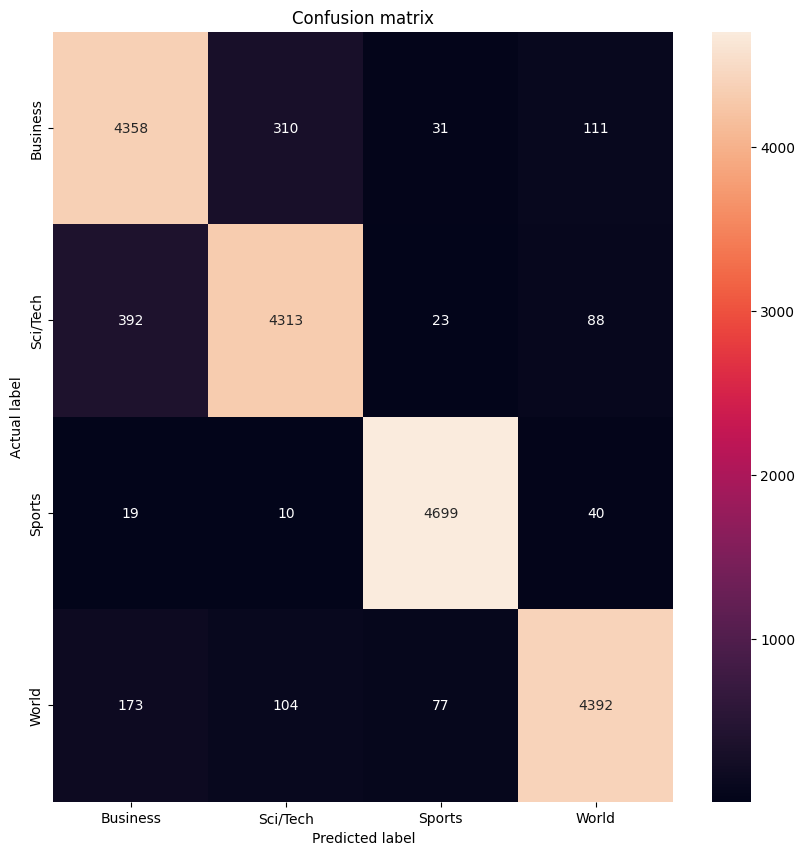

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(real_labels, predicted_real_labels)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

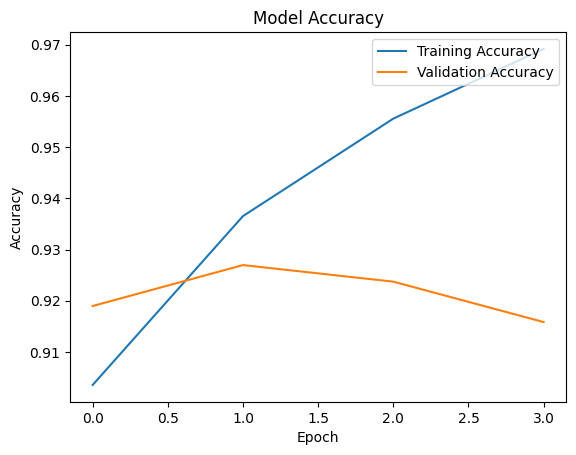

In [ ]:
# Plotting the training and validation loss
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

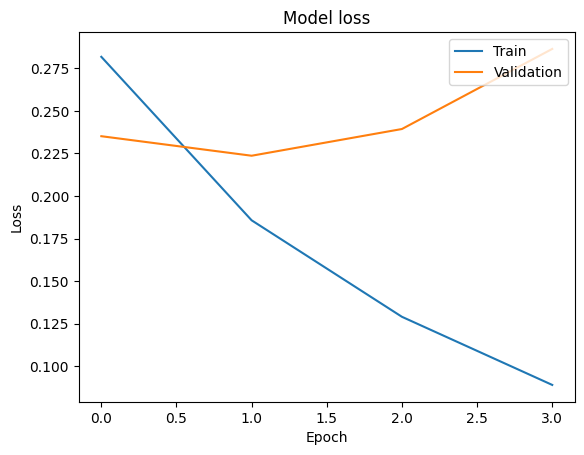

In [ ]:
# Plotting the training and validation loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
incorrect_predictions = cm.sum(axis=1) - np.diag(cm)
most_incorrect_class = np.argmax(incorrect_predictions)
print(f"The category that was predicted most incorrectly is: {encoder.inverse_transform([most_incorrect_class])[0]}")

The category that was predicted most incorrectly is: Sci/Tech


In [ ]:
# Display classification report
from sklearn.metrics import classification_report
print(classification_report(real_labels, predicted_real_labels, target_names=['World', 'Busines', 'Sports', 'Sci/Tech']))

              precision    recall  f1-score   support

       World       0.88      0.91      0.89      4810
     Busines       0.91      0.90      0.90      4816
      Sports       0.97      0.99      0.98      4768
    Sci/Tech       0.95      0.93      0.94      4746

    accuracy                           0.93     19140
   macro avg       0.93      0.93      0.93     19140
weighted avg       0.93      0.93      0.93     19140



In [ ]:
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='micro')}")
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='micro')}")
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='micro')}")

Accuracy: 0.9280041797283176
Precision: 0.9280041797283176
Recall: 0.9280041797283176
F1-score: 0.9280041797283176


In [ ]:
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, pred_classes)}")
print(f"Precision: {sklearn.metrics.precision_score(y_test, pred_classes, average='weighted')}")
print(f"Recall: {sklearn.metrics.recall_score(y_test, pred_classes, average='weighted')}")
print(f"F1-score: {sklearn.metrics.f1_score(y_test, pred_classes, average='weighted')}")

Accuracy: 0.9280041797283176
Precision: 0.9282274802135236
Recall: 0.9280041797283176
F1-score: 0.9280140113587355


# Sample Data

In [ ]:
sample_news = {
    "Business": [
        "United Airlines is ordering 110 additional Boeing and Airbus jetliners, locking in a supply of new planes into the next decade as strong demand and supply chain challenges make new delivery slots scarce. “We would not normally order jets this far out,” United’s chief commercial officer, Andrew Nocella, told reporters Tuesday. “Production lines, which are now regularly plagued by supply-chain disruptions and delivery delays, are also increasingly sold out for the entire decade.” Deliveries of the new planes are scheduled to start in 2028. United’s order consists of 50 more Boeing 787 Dreamliners, adding to a firm order of 100 of the twin-aisle planes it announced last December, along with 50 more options. The airline has aggressively expanded its international service to try to capitalize on a resurgence of trips abroad, destinations that the new long-range 787 planes would serve. The Chicago-based airline is also buying 60 Airbus A321neos, on top of the 120 it previously had on order with the European manufacturer, including 50 of forthcoming extra-long-range version. United added options for 40 more Airbus A321s. United and other airlines have recently ordered new planes have said one way around infrastructure constraints is to operate larger aircraft with more seats on them, a practice known as upgauging. The airline said it expects an average of more than 145 seats per North American departure in 2027, up 40% from 2019."
    ],
    "Sci/Tech": [
        "GOOGLE WENT BIG when it launched its generative AI fight-back against OpenAI's ChatGPT in May. The company added AI text-generation to its signature search engine, showed off an AI-customized version of the Android operating system, and offered up its own chatbot, Bard. But one Google product didn’t get a generative AI infusion: Google Assistant, the company’s answer to Siri and Alexa. Today, at its Pixel hardware event in New York, Google Assistant at last got its upgrade for the ChatGPT era. Sissie Hsiao, Google’s vice president and general manager for Google Assistant, revealed a new version of the AI helper that is a mashup of Google Assistant and Bard. Hsiao says Google envisions this new, “multimodal” assistant to be a tool that goes beyond just voice queries, including by also making sense of images. It can handle “big tasks and small tasks from your to-do list, everything from planning a new trip to summarizing your inbox to writing a fun social media caption for a picture,” she said in an interview with WIRED earlier this week. The new generative AI experience is so early in its rollout that Hsiao said it didn’t even qualify as an “app” yet. When asked for more information about how it might appear on someone’s phone, company representatives were generally unclear on what final form it might take. (Did Google rush out the announcement to coincide with its hardware event? Quite possibly.) Whatever container it appears in, the Bard-ified Google Assistant will use generative AI to process text, voice, or image queries, and respond accordingly in either text or voice. It’s limited to approved users for an unknown period of time, will run on mobile only, not smart speakers, and will require users to opt in. On Android, it may operate as either a full-screen app or as an overlay, similar to how Google Assistant runs today. On iOS, it will likely live within one of Google's apps. The Google Assistant’s generative glow-up comes on the heels of Amazon’s Alexa getting more conversational and OpenAI’s ChatGPT also going multimodal, becoming able to respond using a synthetic voice and describe the content of images shared with the app. One capability apparently unique to Google’s upgraded assistant is an ability to converse about the webpage a user is visiting on their phone. For Google in particular, the introduction of generative AI to its virtual assistant raises questions around how quickly the search giant will start using large language models across more of its products. That could fundamentally change how some of them work—and how Google monetizes them."
    ],
    "Sports": [
        "Jurgen Klopp has called for Liverpool's match against Tottenham to be replayed after the VAR failed to award Luis Diaz's goal which was ruled out for offside. Sky Sports News understands the Premier League's stance remains unchanged - that a replay would not be considered. Klopp said: \"It's really important that as big as football is and important as football is we deal with it in a proper way. All the people involved, the on-field referee, linesman, fourth official and especially in this case VAR, didn't do that on purpose. It was an obvious mistake and I think there would have been solutions for it afterwards. LISTEN: VAR audio released from disallowed Liverpool goal Ref Watch: One little question would have prevented terrible mistake Jones red card stands as Liverpool appeal unsuccessful Stream the Premier League and more with NOW for £21 a month for six months Some people probably don't want me to say, but not as the manager of Liverpool so much, more as a football person, the only outcome should be a replay. That's how it is. It probably will not happen.\" Fulham 1-3 Liverpool | Premier League highlights Fulham 1-3 Liverpool | Premier League highlights Live Scores for Football, Cricket, Rugby, Golf, Tennis, Darts, Racing & F1 Newbury's Greenham Stakes: Horse-by Newbury's Greenham Stakes: Horse-by Live Scores for Football, Cricket, Rugby, Golf, Tennis, Darts, Racing & F1 Trending Papers: Arsenal & Man City set for battle over Bruno Guimaraes Ten Hag hits back at 'embarrassing' media Feyenoord boss Slot a strong candidate to replace Klopp at Liverpool Arteta hails 'unbelievable' effort from Arsenal players as focus switches to Spurs Havertz, White doubles as Arsenal crush Chelsea World Snooker Championship 2024: Draw, results and schedule Poch: When we have bad days, we are so bad Transfer Centre LIVE! Bayern hold discussions with Rangnick PL Predictions: Pickford to star in derby draw Aspinall: Humphries best player in the world 'by a million miles' Watch Latest News Diaz was flagged offside after scoring but replays showed he was actually onside although Darren England, the VAR, mistakenly believed the on-field decision had been to award the goal, leading him to tell Simon Hooper, the referee, that the check was complete. ShareThis is a modal window. Unsupported location The video you are trying to watch cannot be viewed from your current country or location Listen to the audio recording of the VAR discussion that led to Liverpool's wrongly disallowed goal in the 2-1 defeat at Tottenham on Saturday After England and the assistant VAR Dan Cook were alerted to their mistake by the replay operator when the goal wasn't awarded, they repeatedly said they could not intervene as the game had restarted. Also See: Live Premier League table Premier League fixtures Get Sky Sports Get NOW to stream big moments Klopp added: \"The argument against [a replay] will probably be if we open that gate then everybody will ask for it. The situation is so unprecedented that I'm 56 years old and I'm absolutely used to wrong decisions, difficult decisions but something like that as far as I can remember never happened. No decision on England refereeing Liverpool matches for rest of season Sky Sports News understands no decision has yet been taken by PGMOL to stop Darren England refereeing matches involving Liverpool for the rest of the current season. It follows reports that the match official will not take charge of any games involving Jurgen Klopp’s side for the rest of the current campaign after the VAR controversy on Saturday. England was the VAR who failed to overturn an incorrect offside when Luis Diaz’s goal wasn’t given by the on-field team of match officials at the Tottenham Hotspur Stadium. Indications are that for the time being it would be a sensible decision for England not to be involved with Liverpool games given the extent of the fallout from Saturday but it’s too early at this stage to say he won’t officiate any games involving the Merseysiders for the rest of the season. \"That's why I think a replay would be the right thing. If it happened again, a replay would be the right thing to do or the referee has the opportunity to bring both coaches together and say, 'Sorry we made a mistake but we can solve it. Let Liverpool score a goal and we can start from there.' \"I'm not angry with anybody, not at all. We should not go for them. They made a mistake and they felt horrible that night, I'm 100 per cent sure. That's enough for me, nobody needs further punishment.\" Asked whether the club had asked - or would ask - the Premier League for a replay formally, Klopp added: \"At this stage, we are still going through the information we have.\""
    ],
    "World": [
        "'This is all for nothing': Gazans describe finding loved ones in mass graves People in Khan Younis who have been searching for their loved ones in the mass graves discovered in Khan Younis have been speaking to the Sky News team on the ground. Moayed Suleiman Mahmoud Mustafa, 14, whose family was killed in airstrikes, told our team that he found his mother's body in one of the graves and buried her yesterday. He is still looking for his sister, father and his cousin. The teenager said: \"I only found my mother, we buried her yesterday. I am now looking for my sister, my father and my cousin. We took my mother from here and we buried her in our cemetery.\" People in Gaza \"want to rest\", he said. \"We don't want to be living like that, we want to live,\" he added. \"There is no life. This is all for nothing. I feel sad, lonely, alone in the world.\" Reem Zaydan said she was still searching for her son and believed he had been killed in January \"The day my son was martyred, I knew he was martyred without anyone telling me. A mother's instinct,\" she said. \"My son was displaced in an area, and he used to always contact us after any strike or anything. When Khan Younis in its entirety was besieged, he did not call us, unlike every other time. I have been coming here for days. Every day, I come from 6am until 2pm. I come from Rafah city and head to the same place. Once they finish their work, I go home.\" Karima al-Ras, 55, who lives in Khan Younis, said she had found her son after two months of searching for him. \"Today, I came at 6am when I found my son, Ahmad,\" she said. \"His father died when he was 12, and I raised him. I gave him an honourable life. I made him study mechanical engineering. Cars would come to our doorsteps and he would fix them. Ahmad was beloved by everyone.\" The IDF has called claims they buried Palestinian bodies \"baseless and unfounded\". The military said the operation in the area of Nasser Hospital was to locate hostages and missing persons, and bodies \"buried by Palestinians in the area of Nasser Hospital were examined\". \"The examination was carried out respectfully while maintaining the dignity of the deceased. Bodies examined, which did not belong to Israeli hostages, were returned to their place,\" the IDF said.",
        "Climate change indicators reached record levels in 2023: WMO PRESS RELEASE 19 March 2024 The state of the climate in 2023 gave ominous new significance to the phrase 'off the charts.' Key messages State of Global Climate report confirms 2023 as hottest year on record by clear margin Records broken for ocean heat, sea level rise, Antarctic sea ice loss and glacier retreat Extreme weather undermines socio-economic development Renewable energy transition provides hope Cost of climate inaction is higher than cost of climate action Glacial icebergs floating in a calm, icy water with a hazy mountain backdrop. AdobeStock / vitaliymateha A new report from the World Meteorological Organization (WMO) shows that records were once again broken, and in some cases smashed, for greenhouse gas levels, surface temperatures, ocean heat and acidification, sea level rise, Antarctic sea ice cover and glacier retreat. Heatwaves, floods, droughts, wildfires and rapidly intensifying tropical cyclones caused misery and mayhem, upending every-day life for millions and inflicting many billions of dollars in economic losses, according to the WMO State of the Global Climate 2023 report. The WMO report confirmed that 2023 was the warmest year on record, with the global average near-surface temperature at 1.45 °Celsius (with a margin of uncertainty of ± 0.12 °C) above the pre-industrial baseline. It was the warmest ten-year period on record. 'Sirens are blaring across all major indicators... Some records aren’t just chart-topping, they’re chart-busting. And changes are speeding-up.' said United Nations Secretary-General António Guterres. 'Never have we been so close – albeit on a temporary basis at the moment – to the 1.5° C lower limit of the Paris Agreement on climate change.' said WMO Secretary-General Celeste Saulo. 'The WMO community is sounding the Red Alert to the world.' 'Climate change is about much more than temperatures. What we witnessed in 2023, especially with the unprecedented ocean warmth, glacier retreat and Antarctic sea ice loss, is cause for particular concern,' she said. On an average day in 2023, nearly one third of the global ocean was gripped by a marine heatwave, harming vital ecosystems and food systems. Towards the end of 2023, over 90% of the ocean had experienced heatwave conditions at some point during the year. The global set of reference glaciers suffered the largest loss of ice on record (since 1950), driven by extreme melt in both western North America and Europe, according to preliminary data. Antarctic sea ice extent was by far the lowest on record, with the maximum extent at the end of winter at 1 million km2 below the previous record year - equivalent to the size of France and Germany combined. 'The climate crisis is THE defining challenge that humanity faces and is closely intertwined with the inequality crisis – as witnessed by growing food insecurity and population displacement, and biodiversity loss' said Celeste Saulo. Comparison of global mean temperature difference data sets from the 1850s to 2023 relative to the 1850-1900 average. Annual global mean temperature anomalies (relative to 1850–1900) from 1850 to 2023. Data are from six data sets The number of people who are acutely food insecure worldwide has more than doubled, from 149 million people before the COVID-19 pandemic to 333 million people in 2023 (in 78 monitored countries by the World Food Programme). Weather and climate extremes may not be the root cause, but they are aggravating factors, according to the report. Weather hazards continued to trigger displacement in 2023, showing how climate shocks undermine resilience and create new protection risks among the most vulnerable populations. There is, however, a glimmer of hope. Renewable energy generation, primarily driven by the dynamic forces of solar radiation, wind and the water cycle, has surged to the forefront of climate action for its potential to achieve decarbonization targets. In 2023, renewable capacity additions increased by almost 50% from 2022, for a total of 510 gigawatts (GW) – the highest rate observed in the past two decades. This week, at the Copenhagen Climate Ministerial on 21-22 March, climate leaders and ministers from around the world will gather for the first time since COP28 in Dubai to push for accelerated climate action. Enhancing countries Nationally Determined Contributions (NDCs) ahead of the February 2025 deadline, will be high on the agenda, as will delivering an ambitious agreement on financing at COP29 to turn national plans into action. 'Climate Action is currently being hampered by a lack of capacity to deliver and use climate services to inform national mitigation and adaptation plans, especially in developing countries. We need to increase support for National Meteorological and Hydrological Services to be able to provide information services to ensure the next generation of Nationally Determined Contributions are based on science', said Celeste Saulo. The State of the Global Climate report was released in time for World Meteorological Day on 23 March. It also sets the scene for a new climate action campaign by the UN Development Programme and WMO to be launched on 21 March. It will inform discussions at a climate ministerial meeting in Copenhagen on 21-22 March. Dozens of experts and partners contribute to the report, including UN organizations, National Meteorological and Hydrological Services (NMHSs) and Global Data and Analysis Centers, as well as Regional Climate Centres, the World Climate Research Programme (WCRP), the Global Atmosphere Watch (GAW), the Global Cryosphere Watch and Copernicus Climate Change Service operated by ECMWF.",
        "Indian teenager becomes youngest challenger for world chess title, will face reigning champion from China By Andrew McNicol, CNN 3 minute read Updated 2:37 AM EDT, Tue April 23, 2024 Indian grandmaster Gukesh Dommaraju playing at the Freestyle Chess G.O.A.T. Challenge quarter finals in Germany in February. Indian grandmaster Gukesh Dommaraju playing at the Freestyle Chess G.O.A.T. Challenge quarter finals in Germany in February. Marcus Brandt/picture alliance/Getty Images CNN — Teenage Indian chess prodigy Gukesh Dommaraju, better known as Gukesh D, became the youngest player to claim the men’s Candidates Tournament in Toronto, Canada Sunday. The 17-year-old grandmaster’s win sets up an opportunity to dethrone reigning world champion Ding Liren of China at the 2024 World Chess Championship later this year. Should Gukesh beat Ding, who has struggled with poor form recently, he will break Garry Kasparov’s long-held record of being the youngest world champion aged 22. Gukesh, ranked 16th in the world by the International Chess Federation (FIDE), sealed his title after a comfortable draw with world number 3 Hikaru Nakamura, a five-time US chess champion who is more than twice his age. Gukesh is set to become the youngest player ever to challenge for a world chess title. “I was completely emotional but after the game I’m feeling quite good,” Gukesh said in a press conference after finishing atop the round robin tournament. “I don’t really care about [being] the youngest and all these records, but it’s a nice thing to say.” Gukesh was swarmed by Indian fans outside his hotel as the South Asian nation celebrates yet another young chess talent. “I’m very excited to play in the world championship and really looking forward to all the preparations,” he said, adding that his journey is “only halfway through.” The previous youngest winner of a Candidates tournament was Russian prodigy Kasparov, then 20, in 1984. Kasparov, who went on to win multiple world championships, praised Gukesh and the conveyor belt of chess talent coming from both Asia and Asian diaspora communities in countries like the United Stated and Britain. “The Indian earthquake in Toronto is the culmination of the shifting tectonic plates in the chess world,” Kasparov wrote on social media platform X. Indian Prime Minister Narendra Modi also praised Gukesh’s “remarkable achievement” and “extraordinary talent and dedication” on social media. Gukesh will face 31-year-old Chinese star Ding, who was crowed world champion in 2023. The title was previously held by five-time world champion Magnus Carlsen, who had decided not to defend his title at the time. Ding became the first Chinese men’s player in history to become world champion. But the now-world number 5 immediately took a nine-month break from competitions and has struggled with form upon returning. The date and location of the 2024 World Chess Championship between Ding and Gukesh has yet to be revealed. China’s Tan Zhongyi won the women’s Challenger category to qualify for a world title match against compatriot and reigning world champion Ju Wenjun – date also unknown. India, meanwhile, is not short of young chess talent. Joining Gukesh in the men’s Candidates tournament was Rameshbabu Praggnanandhaa (R Praggnanandhaa), 18, who famously stunned the chess world by beating Carlsen in 2022. “Pragg”, as he is known to fans, became the youngest international chess master at the age of 10 and the second-youngest grandmaster in the world at 12. Last year, he and his sister, 22-year-old Rameshbabu Vaishali (R Vaishali), became the first-ever brother and sister duo to obtain grandmaster titles. Gukesh is the second Indian to play in a world championship after legendary Indian player Viswanathan “Vishy” Anand. Gukesh overtook Anand, a five-time world champion and the country’s top player for nearly 40 years, to become India’s top-ranked player last September. “I’m personally very proud of how (Gukesh) played and handled tough situations. Enjoy the moment,” Anand wrote in a post on X."
    ]
}

In [ ]:
# Preprocess each article
sample_news_preprocessed = {category: [remove_stopwords_and_punctuations(article) for article in articles]
                            for category, articles in sample_news.items()}

# Encode each article
sample_encoded = {category: regular_encode(articles, tokenizer, maxlen=200)
                  for category, articles in sample_news_preprocessed.items()}

In [ ]:
# Predict and evaluate each category's articles
for category, encoded_articles in sample_encoded.items():
    article_dataset = tf.data.Dataset.from_tensor_slices(encoded_articles).batch(1)
    predictions = model.predict(article_dataset, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = encoder.inverse_transform(predicted_classes)

    # Output the results
    print(f"\nCategory: {category}")
    for original, predicted in zip(sample_news[category], predicted_labels):
        print(f"Article: {original}\nPredicted Category: {predicted}\n")


1/1 [==============================] - 0s 213ms/step

Category: Business
Article: United Airlines is ordering 110 additional Boeing and Airbus jetliners, locking in a supply of new planes into the next decade as strong demand and supply chain challenges make new delivery slots scarce. “We would not normally order jets this far out,” United’s chief commercial officer, Andrew Nocella, told reporters Tuesday. “Production lines, which are now regularly plagued by supply-chain disruptions and delivery delays, are also increasingly sold out for the entire decade.” Deliveries of the new planes are scheduled to start in 2028. United’s order consists of 50 more Boeing 787 Dreamliners, adding to a firm order of 100 of the twin-aisle planes it announced last December, along with 50 more options. The airline has aggressively expanded its international service to try to capitalize on a resurgence of trips abroad, destinations that the new long-range 787 planes would serve. The Chicago-based airline